# Analysis of Adani Stocks Amidst the Hindenburg Report Impact

In [194]:
# Import necessary libraries
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
sns.set_style('darkgrid')
from sklearn.ensemble import IsolationForest
from scipy import stats
import time
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

## Data Collection
Fetching historical stock prices for Adani Enterprises from Yahoo Finance.

In [128]:
# Define the Adani ticker symbol
ticker = 'ADANIENT.NS'  # NSE ticker for Adani Enterprises

# Get today's date
today = datetime.today().strftime('%Y-%m-%d')

# Fetch historical data from yfinance
adani_stock = yf.download(ticker, start='2022-01-01', end=today)
# Calculate Daily Returns
adani_stock['Daily Return'] = adani_stock['Close'].pct_change()

# Display first few rows
adani_stock.head()



[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume,Daily Return
Ticker,ADANIENT.NS,ADANIENT.NS,ADANIENT.NS,ADANIENT.NS,ADANIENT.NS,
Date,,,,,,
2022-01-03,1714.013794,1729.834821,1708.074588,1709.871349,1094708,NaN
2022-01-04,1715.860596,1724.844159,1696.895295,1722.598268,1191189,0.001077
2022-01-05,1712.316895,1741.463637,1699.440552,1718.854981,1583598,-0.002065
2022-01-06,1709.971313,1720.701681,1672.539800,1706.876999,1615375,-0.001370
2022-01-07,1695.996826,1727.639004,1686.414383,1716.758887,1295933,-0.008172


In [129]:
# Check for missing values
missing_data = adani_stock.isnull().sum()
print("Missing values per column:\n", missing_data)


Missing values per column:
 Price         Ticker     
Close         ADANIENT.NS    0
High          ADANIENT.NS    0
Low           ADANIENT.NS    0
Open          ADANIENT.NS    0
Volume        ADANIENT.NS    0
Daily Return                 1
dtype: int64


In [130]:
# The first value of Daily Return is NaN since there is no previous record.Dropping the row
adani_stock = adani_stock[adani_stock['Daily Return'].notnull()]

# Display the updated DataFrame
adani_stock.head()


Price,Close,High,Low,Open,Volume,Daily Return
Ticker,ADANIENT.NS,ADANIENT.NS,ADANIENT.NS,ADANIENT.NS,ADANIENT.NS,
Date,,,,,,
2022-01-04,1715.860596,1724.844159,1696.895295,1722.598268,1191189,0.001077
2022-01-05,1712.316895,1741.463637,1699.440552,1718.854981,1583598,-0.002065
2022-01-06,1709.971313,1720.701681,1672.539800,1706.876999,1615375,-0.001370
2022-01-07,1695.996826,1727.639004,1686.414383,1716.758887,1295933,-0.008172
2022-01-10,1749.399048,1762.774599,1695.996760,1704.431400,1670551,0.031487


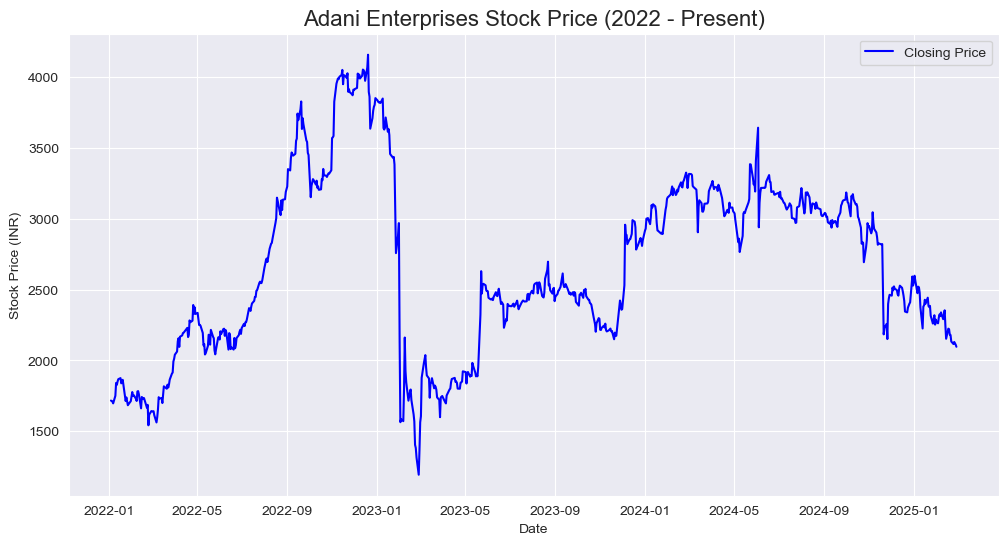

In [131]:
# Plot Adani Enterprises Closing Price
plt.figure(figsize=(12,6))
plt.plot(adani_stock['Close'], label='Closing Price', color='blue')
plt.title('Adani Enterprises Stock Price (2022 - Present)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Stock Price (INR)')
plt.legend()
plt.show()


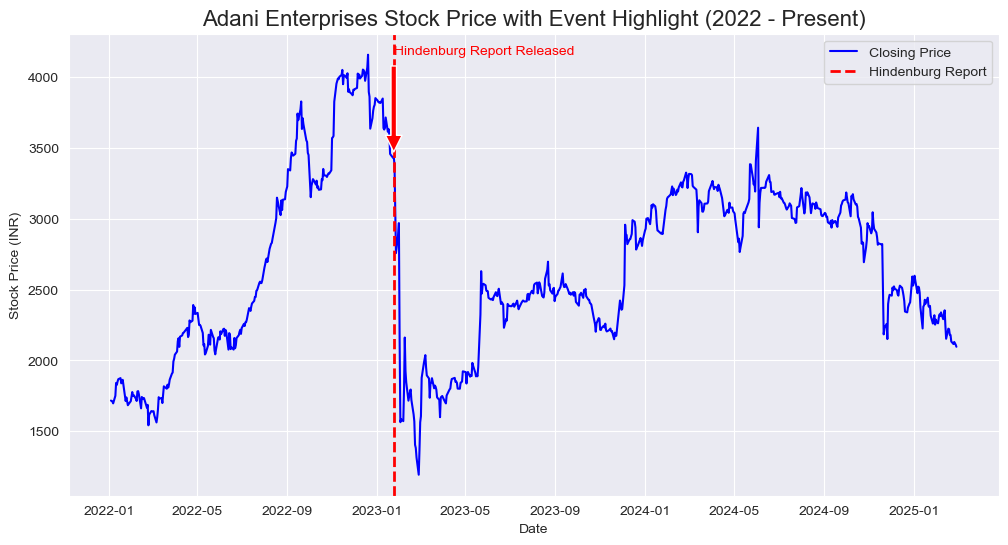

In [132]:
# Plot with Event Highlight
plt.figure(figsize=(12,6))
plt.plot(adani_stock['Close'], label='Closing Price', color='blue')

# Highlight the January 2023 crash event
crash_date = '2023-01-24'  # Date of Hindenburg report release
plt.axvline(pd.to_datetime(crash_date), color='red', linestyle='--', linewidth=2, label='Hindenburg Report')

# Add annotation
plt.annotate('Hindenburg Report Released', xy=(pd.to_datetime(crash_date), adani_stock.loc[crash_date]['Close']),
             xytext=(pd.to_datetime(crash_date), adani_stock['Close'].max()),
             arrowprops=dict(facecolor='red', shrink=0.05),
             fontsize=10, color='red')

# Title and Labels
plt.title('Adani Enterprises Stock Price with Event Highlight (2022 - Present)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Stock Price (INR)')
plt.legend()
plt.show()


- Stock saw strong growth in 2022,peaking before the Hindenburg report in Jan 2023.
- Sharp decline noted,followed by partial recovery but with high volatility, never reaching pre-crash levels.

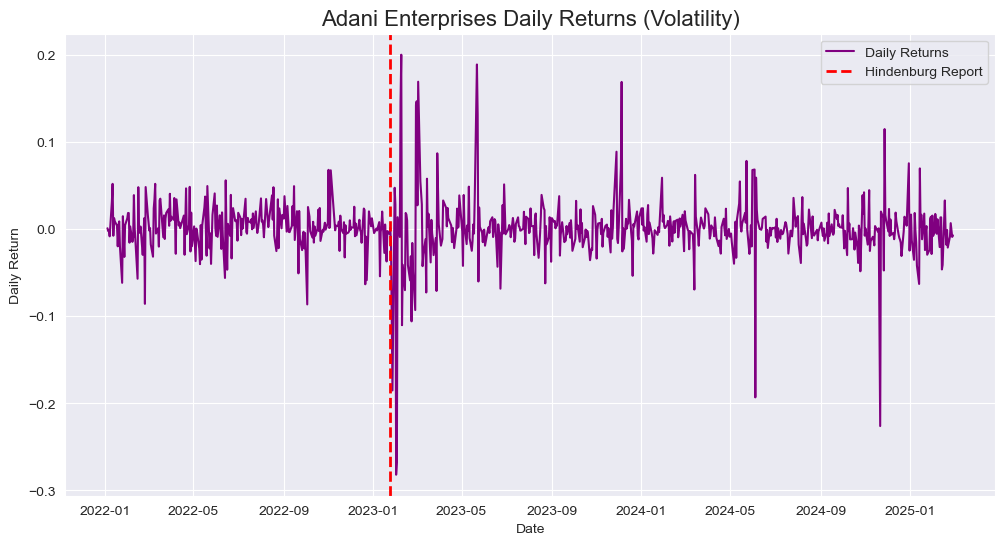

In [134]:
# Plot Daily Returns (Volatility)
plt.figure(figsize=(12,6))
plt.plot(adani_stock['Daily Return'], label='Daily Returns', color='purple')
plt.axvline(pd.to_datetime('2023-01-24'), color='red', linestyle='--', linewidth=2, label='Hindenburg Report')
plt.title('Adani Enterprises Daily Returns (Volatility)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.legend()
plt.show()


- Volatility spiked significantly post-report, showing market panic and uncertainty.
- Daily returns fluctuated wildly, indicating sharp price swings.
- Stabilization followed, but occasional spikes suggest persistent sensitivity to external factors.

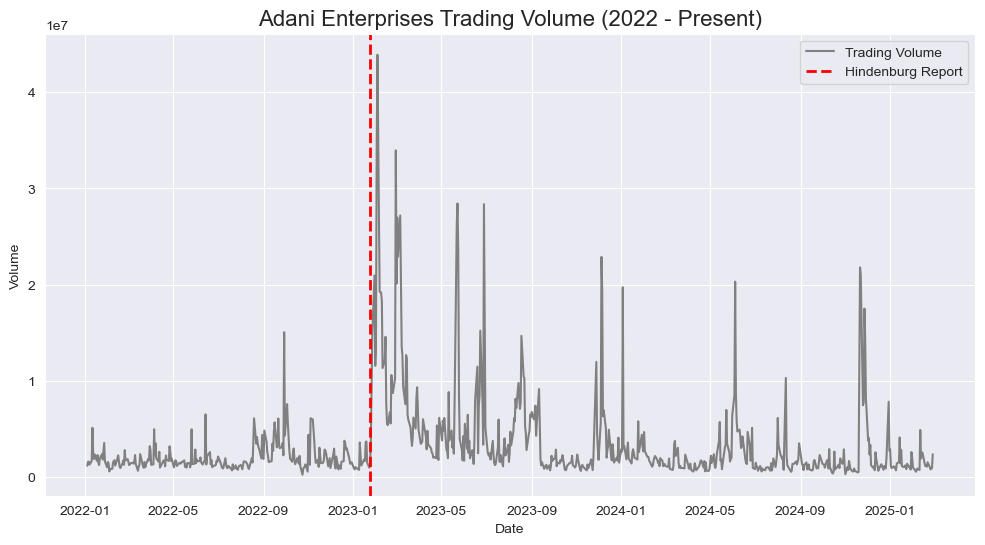

In [136]:
# Plot Trading Volume using a line plot
plt.figure(figsize=(12,6))
plt.plot(adani_stock.index, adani_stock['Volume'], color='grey', label='Trading Volume')
plt.axvline(pd.to_datetime('2023-01-24'), color='red', linestyle='--', linewidth=2, label='Hindenburg Report')
plt.title('Adani Enterprises Trading Volume (2022 - Present)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.show()



- Sharp spike in trading volume immediately after the Hindenburg report, indicating panic-driven sell-offs.
- Multiple surges post-event suggest continued speculative trading and investor reactions to subsequent developments.
- Volume stabilizes but remains volatile, reflecting fluctuating market sentiment and periodic news impacts.

In [138]:
# Define pre- and post-crash periods
pre_crash = adani_stock.loc[adani_stock.index < "2023-01-24"]
post_crash = adani_stock.loc[adani_stock.index >= "2023-01-24"]

# Calculate volatility (standard deviation of daily returns)
pre_volatility = pre_crash['Daily Return'].std()
post_volatility = post_crash['Daily Return'].std()

print(f"📊 Pre-Crash Volatility: {pre_volatility}")
print(f"📊 Post-Crash Volatility: {post_volatility}")

📊 Pre-Crash Volatility: 0.023327981916682932
📊 Post-Crash Volatility: 0.038855535728909735


- Volatility increased by approximately 67% after the crash, indicating higher market uncertainty and --price fluctuations post-event.
- This confirms the significant market impact of the Hindenburg report on Adani stocks.

### Anomaly Detection

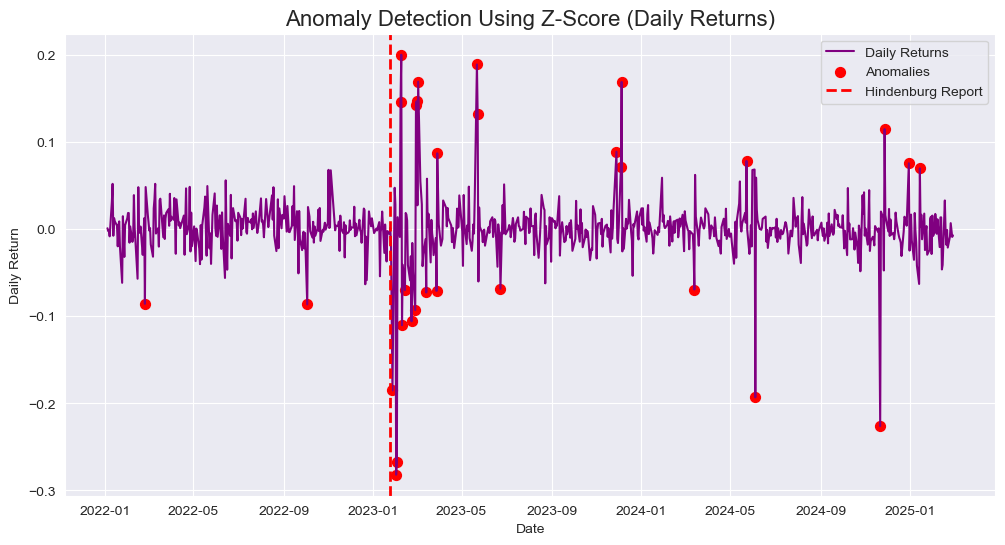

In [141]:


# Calculate Z-Scores for Daily Returns
adani_stock['Z-Score'] = stats.zscore(adani_stock['Daily Return'])

# Define anomaly threshold (e.g., ±2 standard deviations)
threshold = 2

# Flag anomalies
adani_stock['Anomaly_Z'] = adani_stock['Z-Score'].apply(lambda x: 1 if abs(x) > threshold else 0)

# Plot Daily Returns with Anomalies Highlighted
plt.figure(figsize=(12,6))
plt.plot(adani_stock.index, adani_stock['Daily Return'], label='Daily Returns', color='purple')
plt.scatter(adani_stock[adani_stock['Anomaly_Z'] == 1].index, 
            adani_stock[adani_stock['Anomaly_Z'] == 1]['Daily Return'], 
            color='red', label='Anomalies', s=50)

plt.axvline(pd.to_datetime('2023-01-24'), color='red', linestyle='--', linewidth=2, label='Hindenburg Report')
plt.title('Anomaly Detection Using Z-Score (Daily Returns)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.legend()
plt.show()


- Extreme anomalies detected immediately after the Hindenburg report, confirming the massive market shock.
- Post-event anomalies suggest periods of heightened volatility even months later, likely due to continued market reactions.
- Few scattered anomalies pre-event, indicating relatively stable trading before the crash.

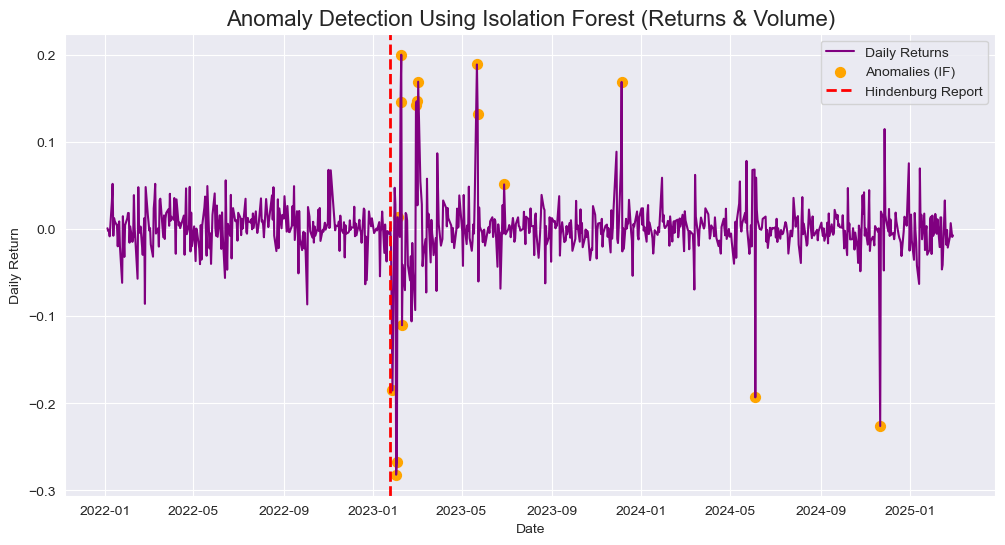

In [143]:


# Prepare data for Isolation Forest
features = adani_stock[['Daily Return', 'Volume']].dropna()

# Initialize Isolation Forest
iso_forest = IsolationForest(contamination=0.02, random_state=42)
features['Anomaly_IF'] = iso_forest.fit_predict(features)

# Map anomalies (-1 for anomaly, 1 for normal)
features['Anomaly_IF'] = features['Anomaly_IF'].map({1: 0, -1: 1})

# Plot Daily Returns with Isolation Forest Anomalies
plt.figure(figsize=(12,6))
plt.plot(features.index, features['Daily Return'], label='Daily Returns', color='purple')
plt.scatter(features[features['Anomaly_IF'] == 1].index, 
            features[features['Anomaly_IF'] == 1]['Daily Return'], 
            color='orange', label='Anomalies (IF)', s=50)

plt.axvline(pd.to_datetime('2023-01-24'), color='red', linestyle='--', linewidth=2, label='Hindenburg Report')
plt.title('Anomaly Detection Using Isolation Forest (Returns & Volume)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.legend()
plt.show()


- Extreme anomalies detected immediately after the Hindenburg report, confirming the massive market shock.
- Post-event anomalies suggest periods of heightened volatility even months later, likely due to continued market reactions.
- Few scattered anomalies pre-event, indicating relatively stable trading before the crash.


### Time series Forecasting

In [146]:


# Perform ADF test
result = adfuller(adani_stock['Close'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])

# Interpretation
if result[1] <= 0.05:
    print("The data is stationary (Reject Null Hypothesis)")
else:
    print("The data is NOT stationary (Fail to Reject Null Hypothesis)")


ADF Statistic: -2.3143267939871235
p-value: 0.1673889201974405
The data is NOT stationary (Fail to Reject Null Hypothesis)


In [147]:
adani_stock['Close_diff'] = adani_stock['Close'].diff().dropna()


In [148]:
adani_stock.head()

Price,Close,High,Low,Open,Volume,Daily Return,Z-Score,Anomaly_Z,Close_diff
Ticker,ADANIENT.NS,ADANIENT.NS,ADANIENT.NS,ADANIENT.NS,ADANIENT.NS,,,,
Date,,,,,,,,,
2022-01-04,1715.860596,1724.844159,1696.895295,1722.598268,1191189,0.001077,0.005965,0,NaN
2022-01-05,1712.316895,1741.463637,1699.440552,1718.854981,1583598,-0.002065,-0.085365,0,-3.543701
2022-01-06,1709.971313,1720.701681,1672.539800,1706.876999,1615375,-0.001370,-0.065155,0,-2.345581
2022-01-07,1695.996826,1727.639004,1686.414383,1716.758887,1295933,-0.008172,-0.262842,0,-13.974487
2022-01-10,1749.399048,1762.774599,1695.996760,1704.431400,1670551,0.031487,0.889696,0,53.402222


### Plotting ACF & PACF plots

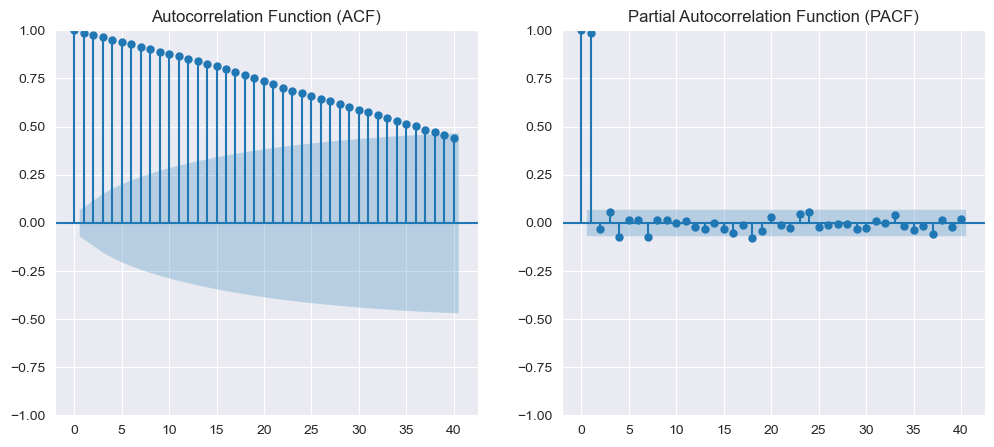

In [150]:

# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(12,5))

# ACF Plot
sm.graphics.tsa.plot_acf(adani_stock['Close'].dropna(), lags=40, ax=axes[0])
axes[0].set_title("Autocorrelation Function (ACF)")

# PACF Plot
sm.graphics.tsa.plot_pacf(adani_stock['Close'].dropna(), lags=40, ax=axes[1])
axes[1].set_title("Partial Autocorrelation Function (PACF)")

plt.show()


- ACF shows high autocorrelation, indicating stock prices follow a strong trend and are not stationary.
- PACF drops sharply after lag 1, suggesting that the immediate past value is the strongest predictor of future values.
- Confirms the need for differencing in ARIMA/SARIMA models to make the series stationary before forecasting.

### ARIMA

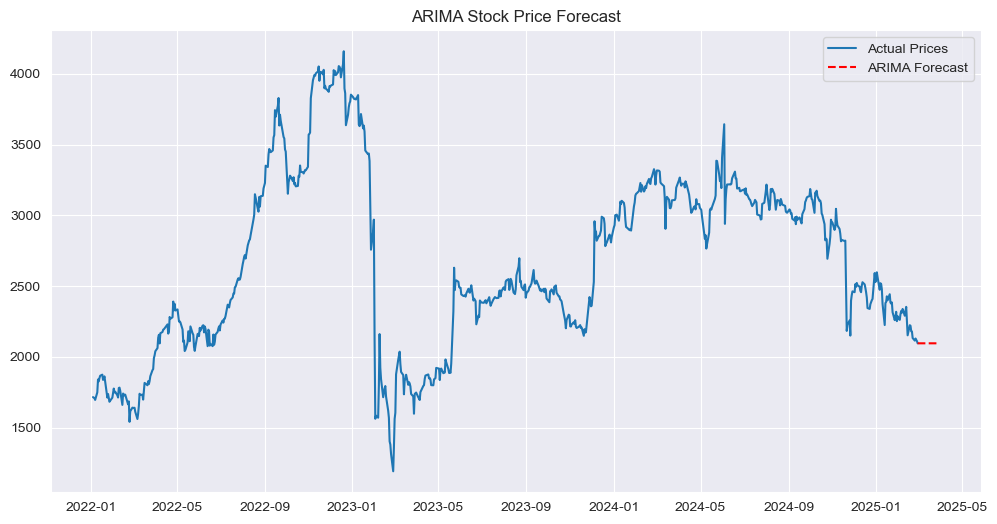

In [153]:

# Define ARIMA model (Replace p, d, q with values from ACF/PACF)
p, d, q = 1, 1, 1
model = ARIMA(adani_stock['Close'], order=(p, d, q))
arima_result = model.fit()

# Forecast future prices
forecast_steps = 30  # Predict next 30 days
forecast = arima_result.forecast(steps=forecast_steps)

# Convert forecast into NumPy array
arima_forecast = np.array(forecast)
# Plot forecast
plt.figure(figsize=(12,6))
plt.plot(adani_stock['Close'], label="Actual Prices")
plt.plot(pd.date_range(start=adani_stock.index[-1], periods=forecast_steps, freq='D'), 
         forecast, label="ARIMA Forecast", linestyle="dashed", color="red")
plt.legend()
plt.title("ARIMA Stock Price Forecast")
plt.show()


### SARIMA

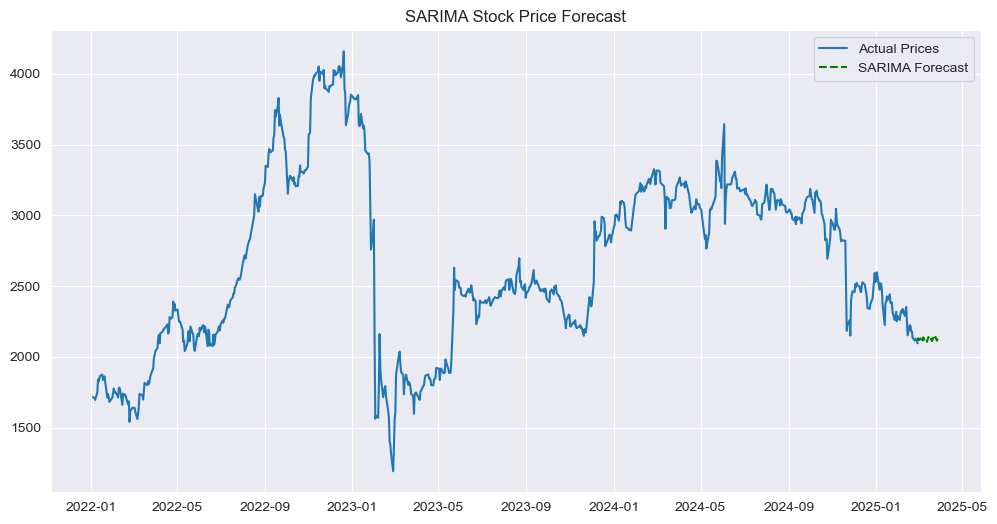

In [155]:


# Fit SARIMA model (Replace p, d, q, P, D, Q, s)
p, d, q = 1, 1, 1
P, D, Q, s = 1, 1, 1, 7  # s=7 for weekly seasonality

sarima_model = SARIMAX(adani_stock['Close'], 
                        order=(p, d, q), 
                        seasonal_order=(P, D, Q, s))
sarima_result = sarima_model.fit()

# Forecast future prices
forecast_steps = 30  # Predict next 30 days
sarima_forecast = sarima_result.forecast(steps=forecast_steps)
# Convert forecast into NumPy array
sarima_forecast = np.array(sarima_forecast)
# Forecast future prices
sarima_forecast = sarima_result.forecast(steps=forecast_steps)

# Plot SARIMA forecast
plt.figure(figsize=(12,6))
plt.plot(adani_stock['Close'], label="Actual Prices")
plt.plot(pd.date_range(start=adani_stock.index[-1], periods=forecast_steps, freq='D'), 
         sarima_forecast, label="SARIMA Forecast", linestyle="dashed", color="green")
plt.legend()
plt.title("SARIMA Stock Price Forecast")
plt.show()


### Model Evaluation

In [157]:


# Extract actual closing prices for the forecasted period
actual_prices = adani_stock['Close'].iloc[-forecast_steps:].values  # Ensure same period as forecasts

# Compute RMSE
rmse_arima = np.sqrt(mean_squared_error(actual_prices, arima_forecast))
rmse_sarima = np.sqrt(mean_squared_error(actual_prices, sarima_forecast))

# Compute MAPE
mape_arima = mean_absolute_percentage_error(actual_prices, arima_forecast)
mape_sarima = mean_absolute_percentage_error(actual_prices, sarima_forecast)

print(f"📊 ARIMA RMSE: {rmse_arima}, MAPE: {mape_arima}")
print(f"📊 SARIMA RMSE: {rmse_sarima}, MAPE: {mape_sarima}")



📊 ARIMA RMSE: 189.27081366397255, MAPE: 0.07201524902444371
📊 SARIMA RMSE: 164.918621806849, MAPE: 0.061298763597595125


- SARIMA outperforms ARIMA in terms of lower RMSE, indicating a better absolute error fit.
- SARIMA also has a lower MAPE, suggesting better percentage-based accuracy.
- SARIMA provides a more accurate forecast than ARIMA in both RMSE and MAPE, showing that incorporating seasonality improved model performance.

**Disclaimer: The visualizations and analyses presented in this project are intended solely for demonstrating time series forecasting and anomaly detection techniques. These models do not serve as financial advice or accurate predictions, as they do not account for real-world complexities, market sentiment, or external economic factors.**